# Packages Import

In [371]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [372]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("pastel")

# Data Import

In [373]:
customers = pd.read_csv("customers.csv")

In [374]:
customers.head()

,Unnamed: 0,customer_unique_id,order_frequency,total_price,mean_item_count,mean_category_count,review_score,comment,payment_installments,payment_type_count,late_delivery,recency
0,0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1.0,1.0,5.0,1.0,8.0,1.0,0,111
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1.0,1.0,4.0,0.0,1.0,1.0,0,114
2,2,0000f46a3911fa3c0805444483337064,1,86.22,1.0,1.0,3.0,0.0,8.0,1.0,0,536
3,3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1.0,1.0,4.0,1.0,4.0,1.0,0,320
4,4,0004aac84e0df4da2b147fca70cf8255,1,196.89,1.0,1.0,5.0,0.0,6.0,1.0,0,287


In [375]:
customers.drop(columns=["Unnamed: 0", "customer_unique_id"], inplace=True)

# Analysis

## Correlations

<Axes: >

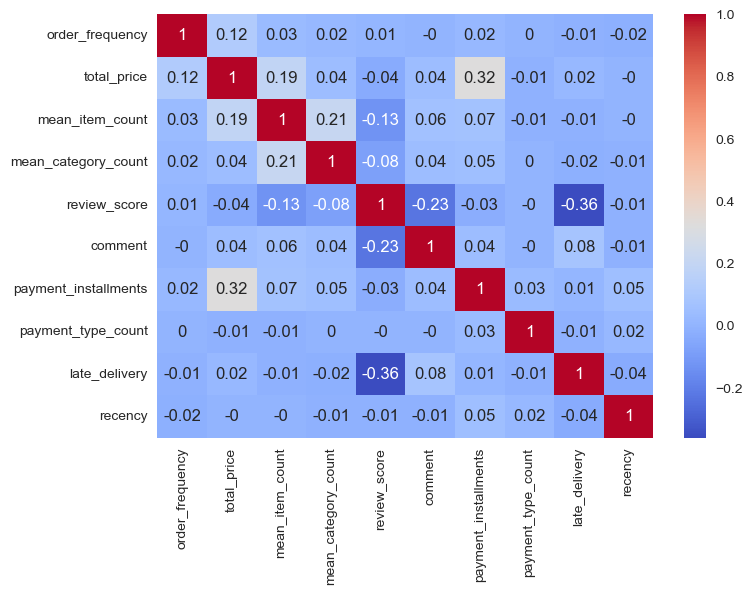

In [376]:
sns.heatmap(
    data=customers.corr(numeric_only=True).round(2),
    cmap="coolwarm",
    annot=True,
)

## Distributions

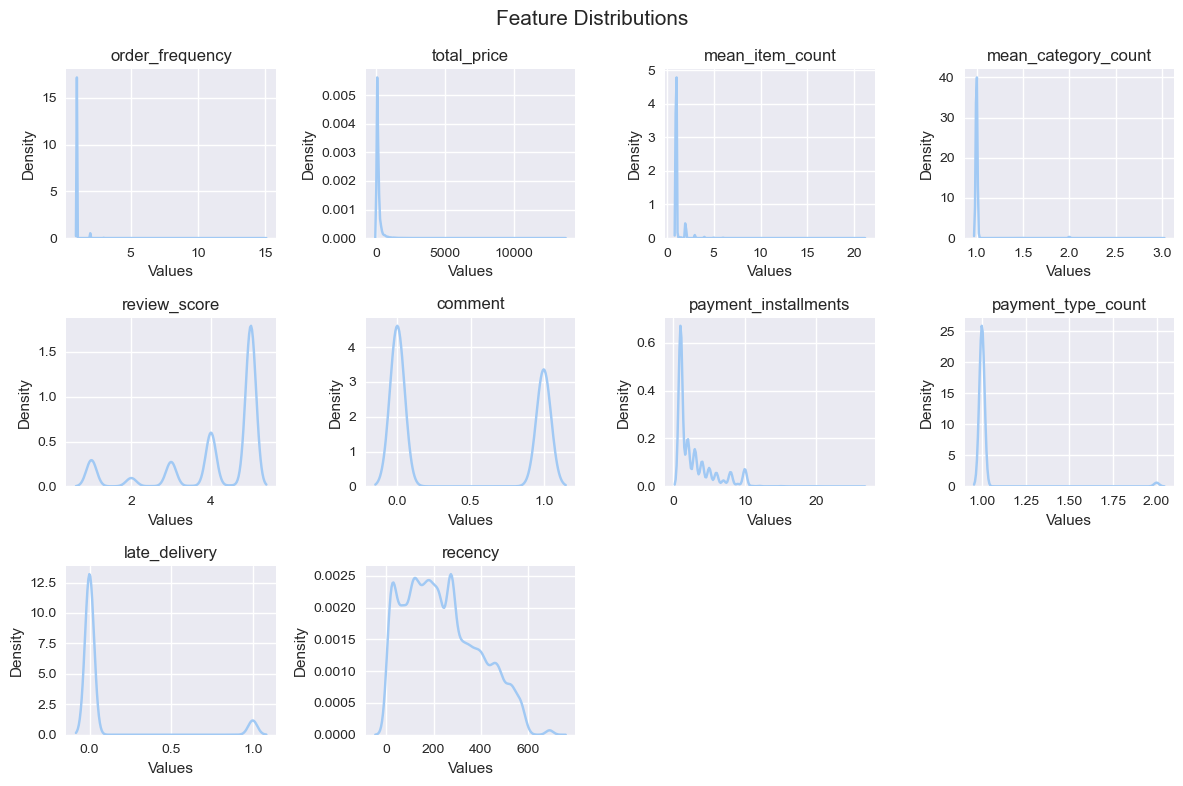

In [377]:
def kde_plots(df):
    columns = df.columns
    n_cols = 4
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, 4, figsize=(12, 8))
    for i, column in enumerate(columns):
        row_idx = i // n_cols
        col_idx = i % n_cols
        ax = axes[row_idx, col_idx]

        sns.kdeplot(df[column], ax=ax)

        ax.set_title(f"{column}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")

    if i + 1 < n_rows * n_cols:
        for j in range(i + 1, n_rows * n_cols):
            axes.flat[j].set_visible(False)

    fig.suptitle("Feature Distributions", fontsize=15)
    plt.tight_layout()
    plt.show()


kde_plots(customers)

We can log transform our data to normalize the distributions which can help the PCA render better results with non-linear relationships

In [378]:
# customers = np.log10(customers + 1)

# kde_plots(customers)

## PCA

In [379]:
def scree_plot(pca, feature_count):
    variance_ratio = (pca.explained_variance_ratio_ * 100).round(2)
    variance_ratio_cum = variance_ratio.cumsum().round()

    x_list = range(1, feature_count + 1)
    plt.figure(figsize=(8, 4))
    plt.bar(x_list, variance_ratio)
    for index, value in enumerate(variance_ratio):
        plt.text(index + 1, value, str(value), ha="center", va="bottom")
    plt.xticks(np.arange(0, feature_count + 1, 1))
    plt.plot(x_list, variance_ratio_cum, c="red", marker="o")
    plt.xlabel("Components")
    plt.ylabel("Variance ratio")
    plt.title("Scree plot")
    plt.show()

In [380]:
def plot_correlation_circle(pca, features, components):
    fig = plt.figure(figsize=(12, 5))
    num = 0
    for x, y in components:
        num += 1
        ax = plt.subplot(1, 2, num)
        for i in range(0, pca.components_.shape[1]):
            ax.arrow(
                0,
                0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.04,
                head_length=0.04,
                width=0.02,
            )
            ax.text(
                pca.components_[x, i] + 0.02, pca.components_[y, i] + 0.02, features[i]
            )
        plt.plot([-1, 1], [0, 0], color="grey", ls="--")
        plt.plot([0, 0], [-1, 1], color="grey", ls="--")

        ax.set_xlabel(
            "F{} ({}%)".format(x + 1, round(100 * pca.explained_variance_ratio_[x], 1))
        )
        ax.set_ylabel(
            "F{} ({}%)".format(y + 1, round(100 * pca.explained_variance_ratio_[y], 1))
        )
        ax.set_title("Correlations (F{} et F{})".format(x + 1, y + 1))
        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an))
        plt.axis("equal")
    plt.show()

In [381]:
def display_factorial_planes(X_projected, components, pca):
    X_ = np.array(X_projected)
    fig = plt.figure(figsize=(12, 4))
    num = 0
    for x, y in components:
        num += 1
        ax = plt.subplot(1, 2, num)

        sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], ax=ax)

        v1 = str(round(100 * pca.explained_variance_ratio_[x])) + " %"
        v2 = str(round(100 * pca.explained_variance_ratio_[y])) + " %"

        ax.set_xlabel(f"F{x+1} {v1}")
        ax.set_ylabel(f"F{y+1} {v2}")

        x_max = np.abs(X_[:, x]).max() * 1.1
        y_max = np.abs(X_[:, y]).max() * 1.1

        ax.set_xlim(left=-x_max, right=x_max)
        ax.set_ylim(bottom=-y_max, top=y_max)

        plt.plot([-x_max, x_max], [0, 0], color="grey", alpha=0.8)
        plt.plot([0, 0], [-y_max, y_max], color="grey", alpha=0.8)
    plt.show()

In [382]:
def scale(df):
    scaler = StandardScaler()
    return scaler.fit_transform(df)

### PCA on all features 

In [383]:
customers.columns

Index(['order_frequency', 'total_price', 'mean_item_count',
       'mean_category_count', 'review_score', 'comment',
       'payment_installments', 'payment_type_count', 'late_delivery',
       'recency'],
      dtype='object')

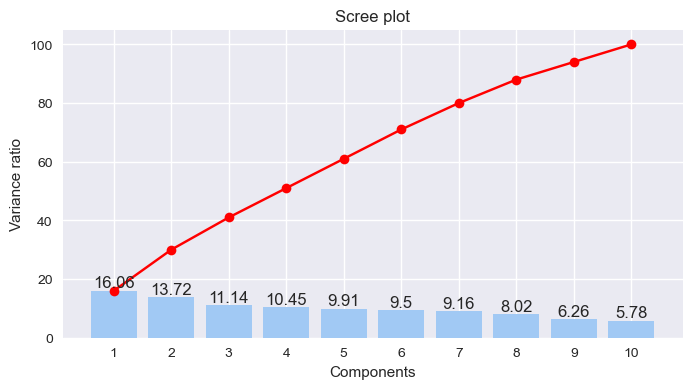

In [384]:
feature_count = len(customers.columns)
pca = PCA(n_components=feature_count)
customers_scaled = scale(customers)
pca.fit(customers_scaled)
scree_plot(pca, feature_count)

Overall this PCA does not help to reduce the dimentionality of our dataset

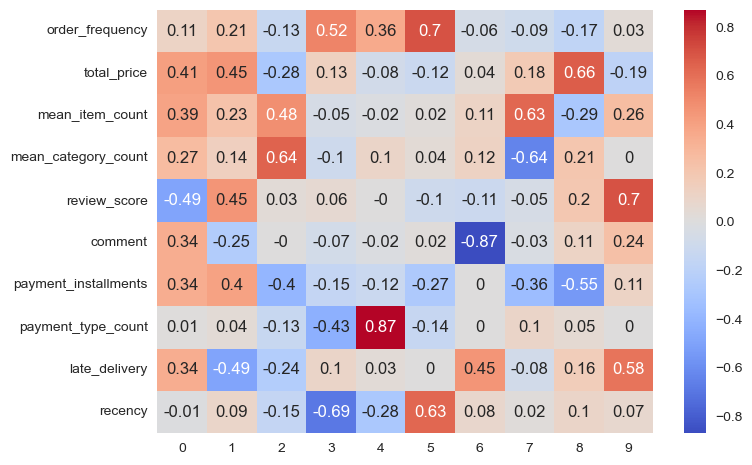

In [385]:
sns.heatmap(
    pd.DataFrame(pca.components_, columns=customers.columns).round(2).T,
    cmap="coolwarm",
    annot=True,
)
plt.show()

There are 6 features that contribute the most to the first component. 

Overall we see correlations between recency and frequency, late delivery, review score and comments, and between the price and the number of items, categories and payment installments.

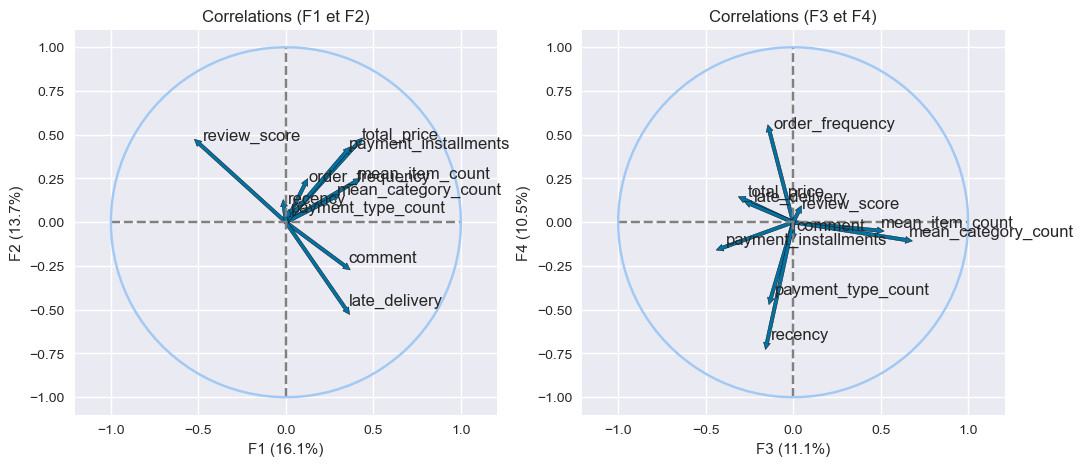

In [386]:
plot_correlation_circle(pca, customers.columns, [(0, 1), (2, 3)])

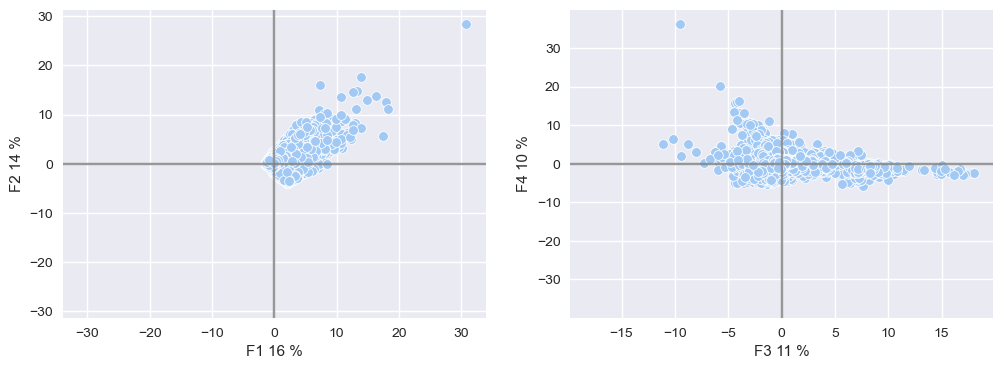

In [387]:
display_factorial_planes(pca.transform(customers_scaled), [(0, 1), (2, 3)], pca)

### RFM PCA 

We'll perform the PCA on RFM features 

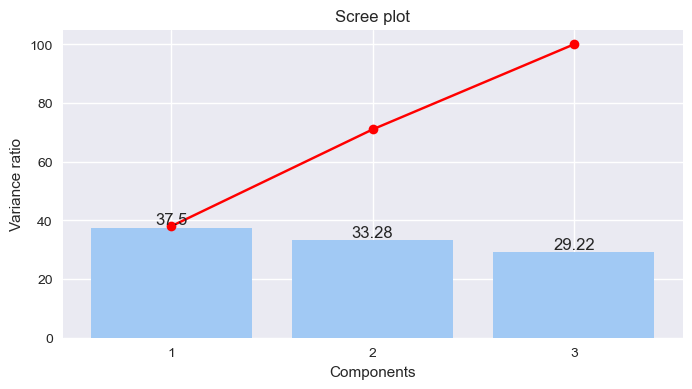

In [388]:
rfm_subset = customers[["order_frequency", "total_price", "recency"]]

rfm_pca = PCA(n_components=3)
scaled_data = scale(rfm_subset)
rfm_pca.fit(scaled_data)
scree_plot(rfm_pca, 3)

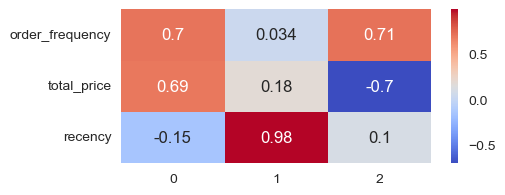

In [389]:
components = pd.DataFrame(rfm_pca.components_, columns=rfm_subset.columns)

plt.figure(figsize=[5, 2])
sns.heatmap(
    components.T,
    cmap="coolwarm",
    annot=True,
)
plt.show()

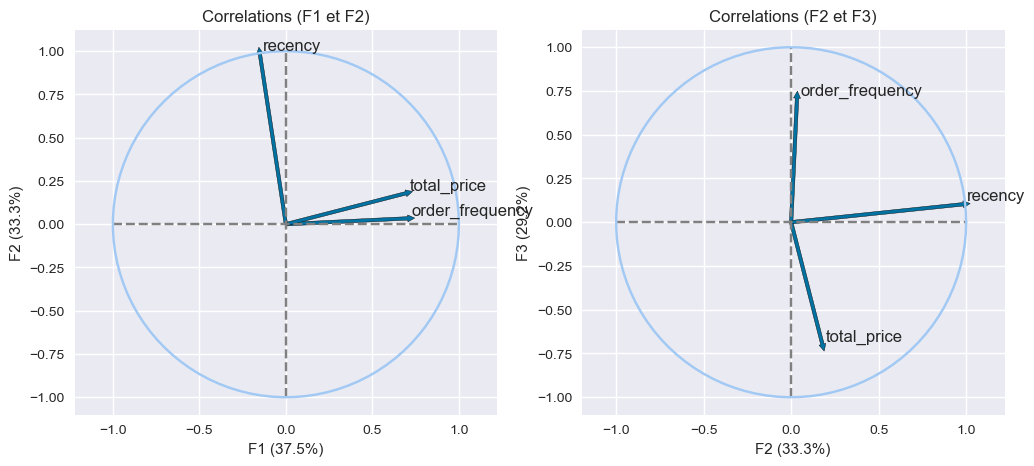

In [390]:
plot_correlation_circle(rfm_pca, rfm_subset.columns, [(0, 1), (1, 2)])

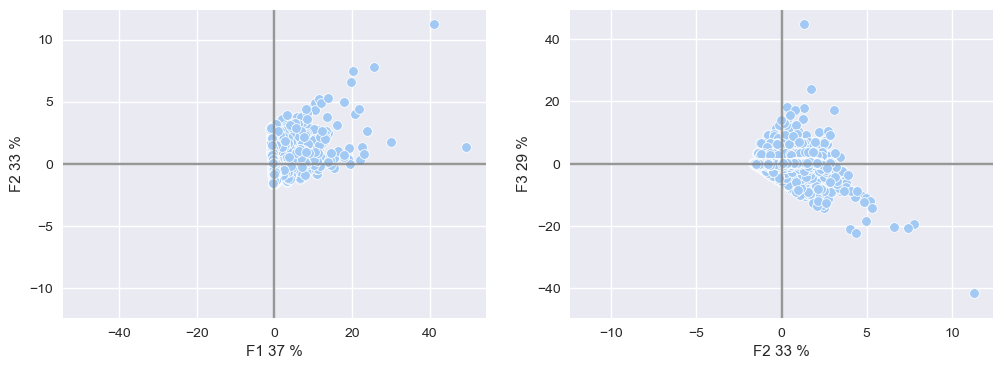

In [391]:
rfm_projected = rfm_pca.transform(scaled_data)
display_factorial_planes(rfm_projected, [(0, 1), (1, 2)], rfm_pca)

We'll use TSNE to see if we can capture other relationships in the data where the PCA cannot

<Axes: >

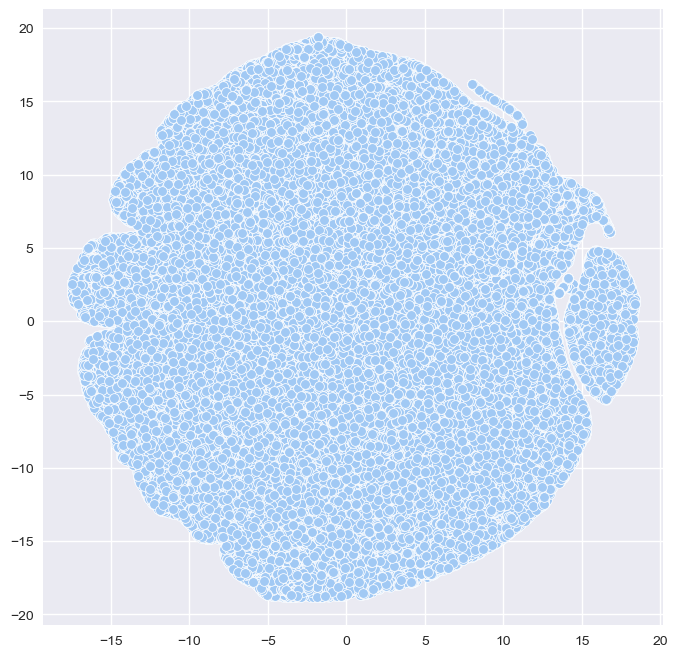

In [392]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, n_jobs=-1, init="pca")
T = tsne.fit_transform(rfm_projected)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=T[:, 0], y=T[:, 1])

There are two main clusters, we'll see if we can visualize better relationships with more features

### PCA on RFM and Feedback

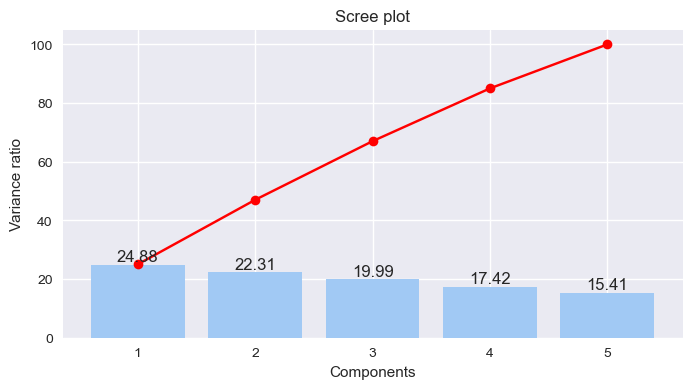

In [393]:
subset = customers[
    ["order_frequency", "total_price", "recency", "review_score", "comment"]
]

subset_pca = PCA(n_components=5)
scaled_data = scale(subset)
subset_pca.fit(scaled_data)
scree_plot(subset_pca, 5)

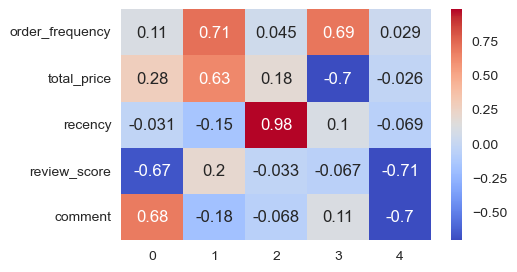

In [394]:
components = pd.DataFrame(subset_pca.components_, columns=subset.columns)

plt.figure(figsize=[5, 3])
sns.heatmap(
    components.T,
    cmap="coolwarm",
    annot=True,
)
plt.show()

With this subset of features, the first component explains a significant percentage of the variance 

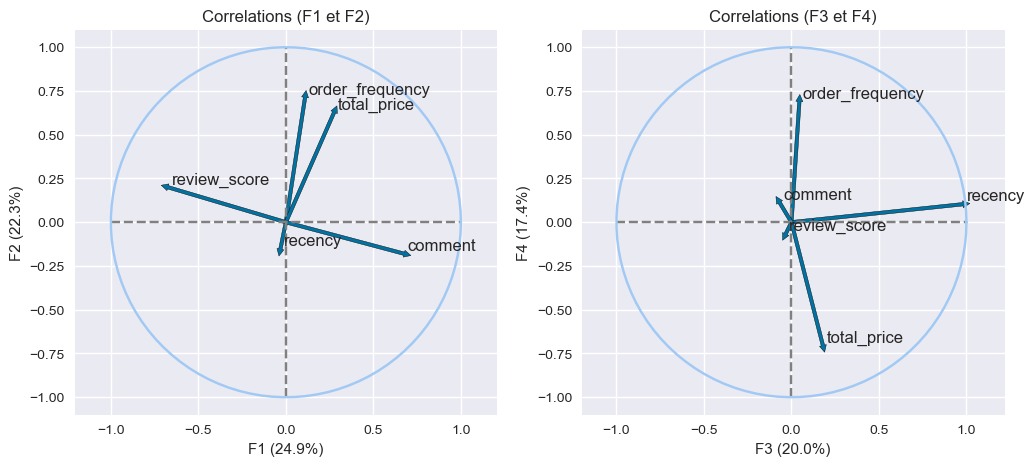

In [395]:
plot_correlation_circle(subset_pca, subset.columns, [(0, 1), (2, 3)])

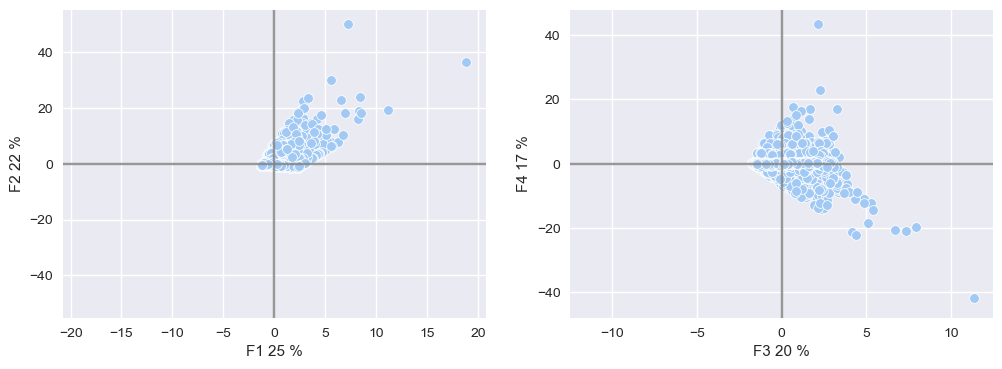

In [396]:
subset_projected_values = subset_pca.transform(scaled_data)

display_factorial_planes(
    subset_projected_values,
    [(0, 1), (2, 3)],
    subset_pca,
)

<Axes: >

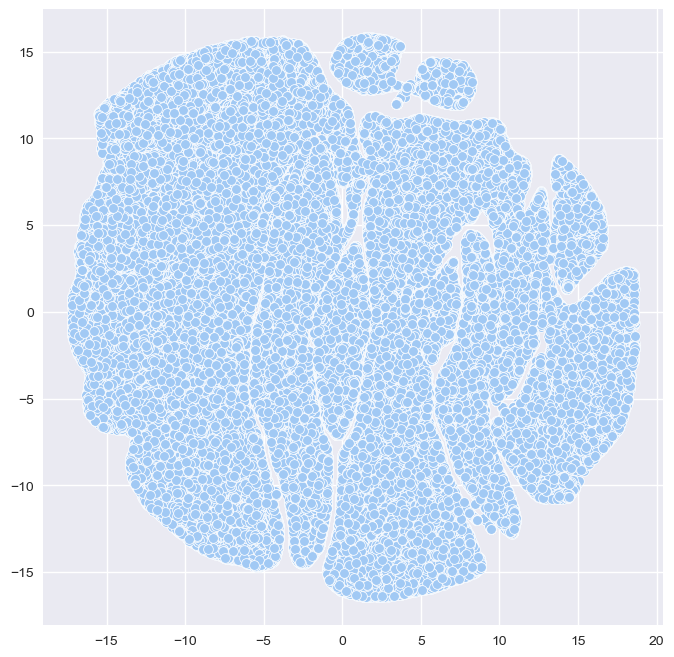

In [397]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=300, n_jobs=-1, init="pca")
T = tsne.fit_transform(subset_projected_values)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=T[:, 0], y=T[:, 1])

The clusters are more evident 

### PCA on Satisfaction features

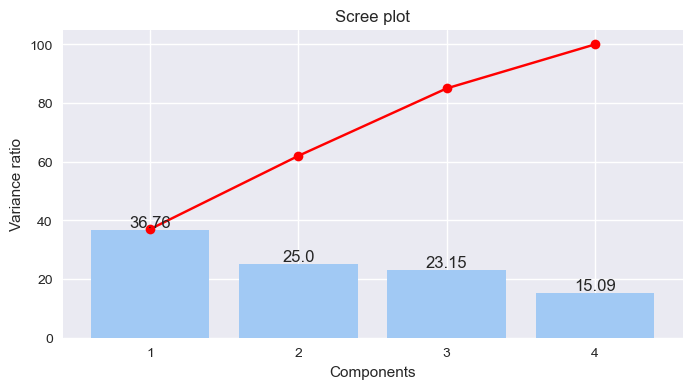

In [398]:
satisfaction_subset = customers[
    ["order_frequency", "late_delivery", "review_score", "comment"]
]

satisfaction_pca = PCA(n_components=4)
satisfaction_scaled = scale(satisfaction_subset)
satisfaction_pca.fit(satisfaction_scaled)
scree_plot(satisfaction_pca, 4)

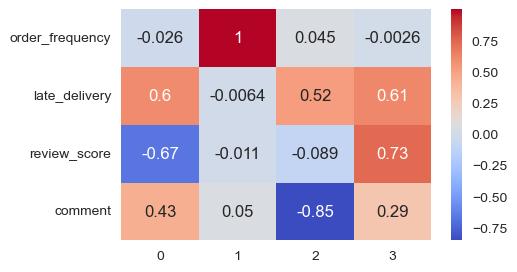

In [399]:
components = pd.DataFrame(
    satisfaction_pca.components_, columns=satisfaction_subset.columns
)

plt.figure(figsize=[5, 3])
sns.heatmap(
    components.T,
    cmap="coolwarm",
    annot=True,
)
plt.show()

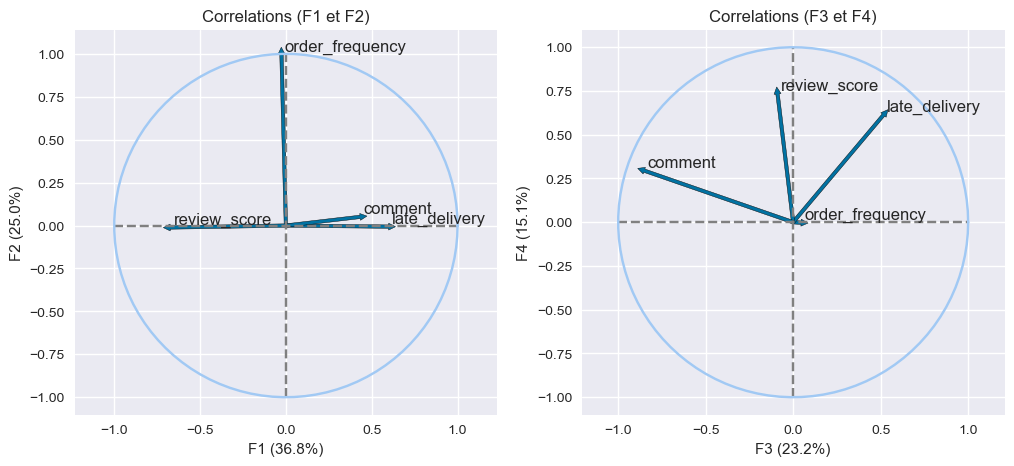

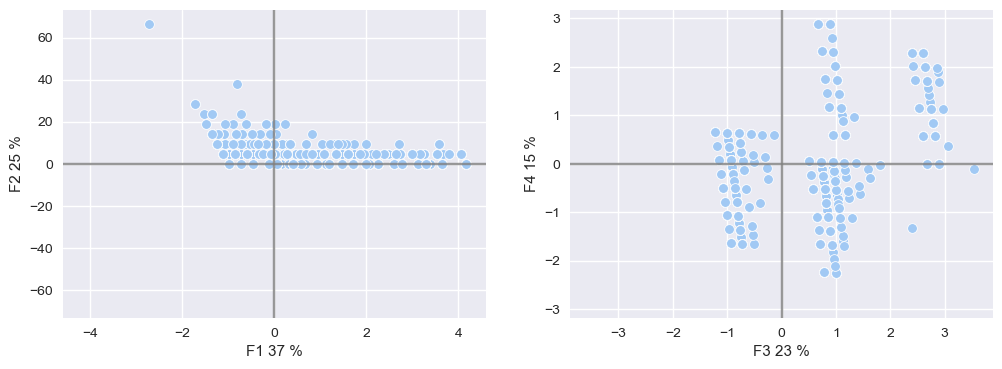

In [400]:
satisfaction_projection = satisfaction_pca.transform(satisfaction_scaled)
plot_correlation_circle(satisfaction_pca, satisfaction_subset.columns, [(0, 1), (2, 3)])

display_factorial_planes(
    satisfaction_projection,
    [(0, 1), (2, 3)],
    satisfaction_pca,
)

# Models 

### RFM

Let's first focus on RFM related features

#### Finding optimal number of clusters

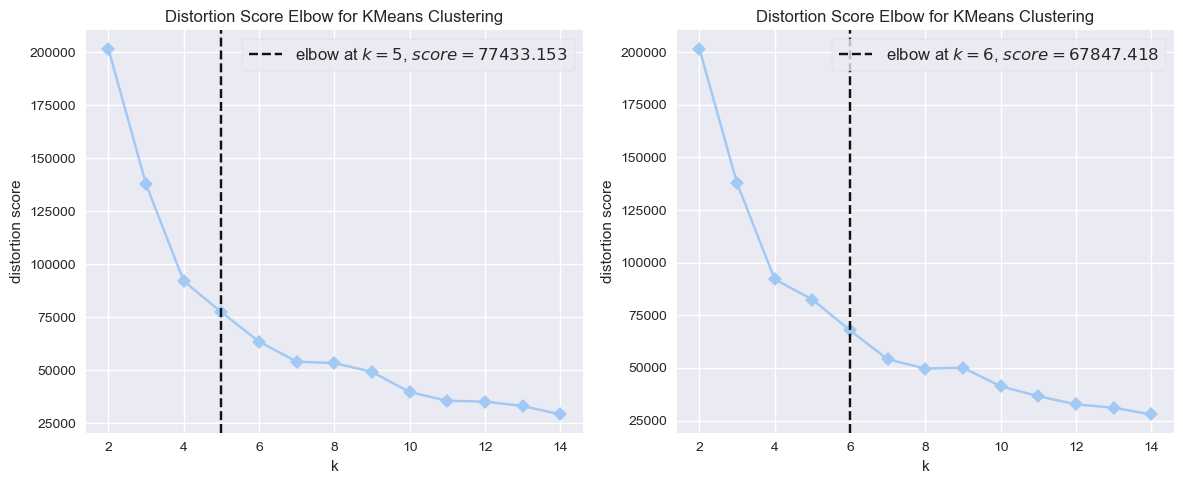

In [437]:
rfm_scaled = scale(rfm_subset)


def elbow(X):
    model = KMeans(n_init="auto")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    visualgrid = [
        KElbowVisualizer(model, k=(2, 15), timings=False, ax=axes[0]),
        KElbowVisualizer(
            model, k=(2, 15), timings=False, metric="silhouette", ax=axes[1]
        ),
    ]

    for viz in visualgrid:
        viz.fit(X)
        viz.finalize()

    plt.tight_layout()
    plt.show()


elbow(rfm_scaled)

In [427]:
def visualize_silhouette(X, clusters):
    num_plots = len(clusters)

    if num_plots == 1:
        model = KMeans(n_clusters=clusters[0], n_init="auto")
        visualizer = SilhouetteVisualizer(model)
        visualizer.fit(X=X)
        visualizer.poof()
        return

    num_rows = num_plots // 2 if num_plots % 2 == 0 else (num_plots // 2) + 1
    num_cols = 2 if num_plots > 1 else 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))
    axes = axes.flatten()

    for n_clusters, ax in zip(clusters, axes):
        model = KMeans(n_clusters=n_clusters, n_init="auto")
        visualizer = SilhouetteVisualizer(model, ax=ax)
        visualizer.fit(X=X)
        visualizer.poof()

    plt.tight_layout()
    plt.show()

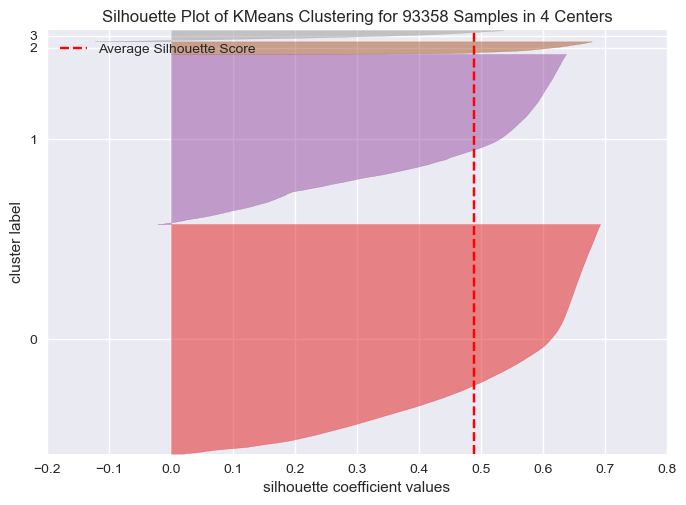

AttributeError: 'Axes' object has no attribute 'flatten'

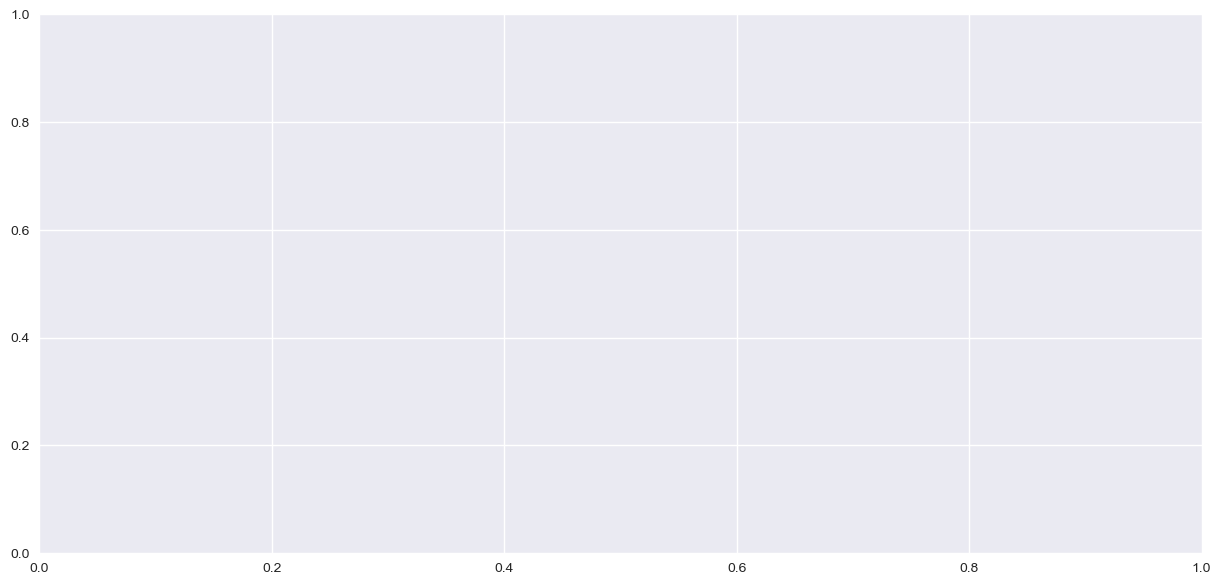

In [428]:
visualize_silhouette(rfm_scaled, [4])

#### Visualizing clusters

In [ ]:
rfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm_subset.columns)
rfm_scaled

,order_frequency,total_price,recency
0,-0.159829,-0.102824,-0.825357
1,-0.159829,-0.609738,-0.805697
2,-0.159829,-0.348879,1.959873
3,-0.159829,-0.537133,0.544321
4,-0.159829,0.140181,0.328056
...,...,...,...
93353,-0.159829,8.406223,1.370059
93354,-0.159829,-0.356127,0.157665
93355,-0.159829,-0.232922,2.163031
93356,-0.159829,-0.139105,-0.779483


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
labels = kmeans.fit_predict(rfm_scaled)
rfm_scaled["cluster"] = labels

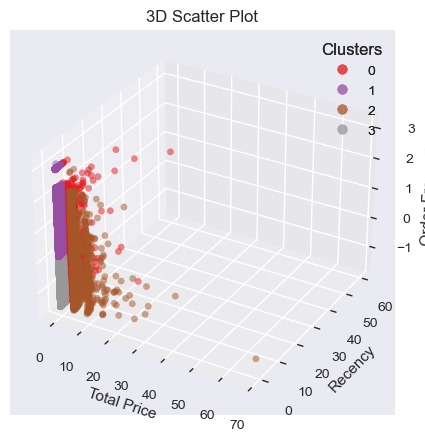

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    rfm_scaled["order_frequency"],
    rfm_scaled["total_price"],
    rfm_scaled["recency"],
    c=rfm_scaled["cluster"],
    cmap="Set1",
    alpha=0.5,
)

ax.set_xlabel("Total Price")
ax.set_ylabel("Recency")
ax.set_zlabel("Order Frequency")
ax.set_title("3D Scatter Plot")

legend1 = ax.legend(*scatter.legend_elements(),
                    title="Clusters", loc="upper right")
ax.add_artist(legend1)

plt.show()

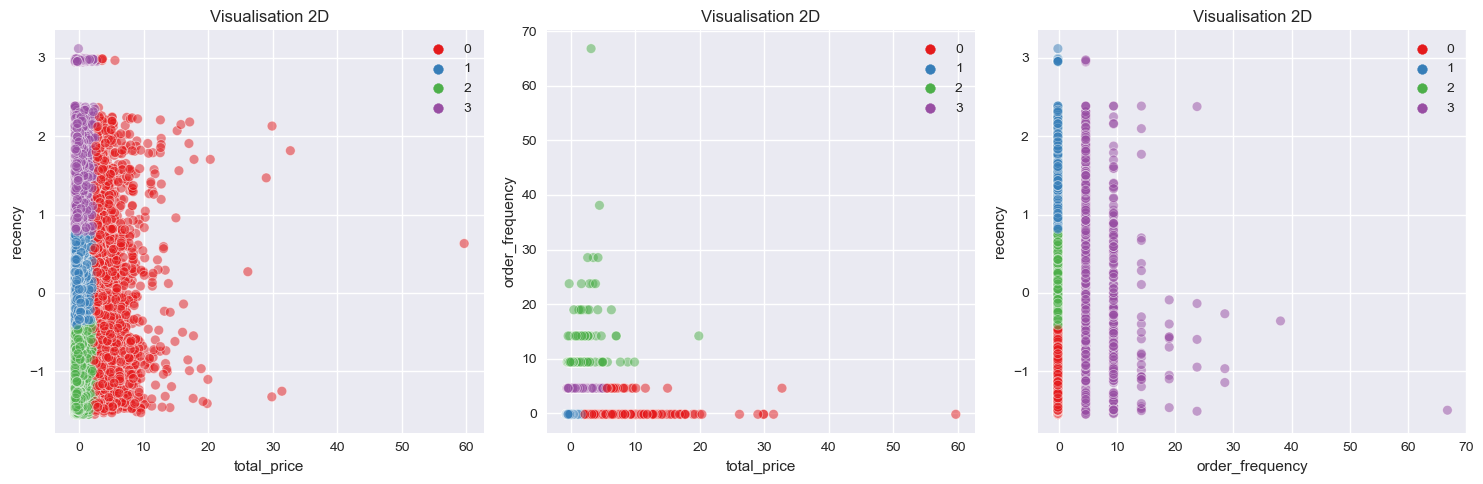

In [ ]:
def plot_clusters(X, components, n_clusters):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()
    for component, ax in zip(components, axes):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
        labels = kmeans.fit_predict(X[component])
        sns.scatterplot(
            x=X[component[0]],
            y=X[component[1]],
            hue=labels,
            palette="Set1",
            data=X[component],
            legend="full",
            alpha=0.5,
            ax=ax,
        ).set(title="Visualisation 2D")

    plt.tight_layout()
    plt.show()


plot_clusters(
    rfm_scaled,
    [
        ["total_price", "recency"],
        ["total_price", "order_frequency"],
        ["order_frequency", "recency"],
    ],
    4,
)

<Axes: >

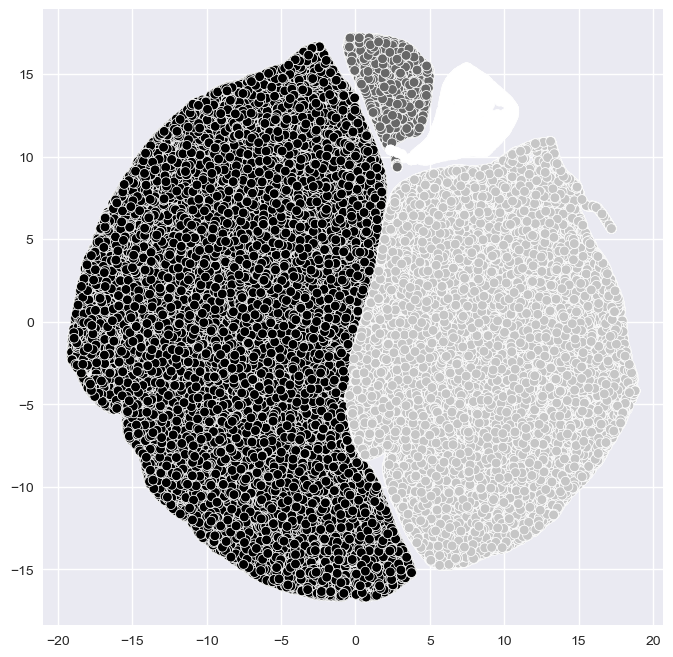

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=300, n_jobs=-1, init="pca")
T = tsne.fit_transform(rfm_scaled)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=T[:, 0], y=T[:, 1], c=rfm_scaled["cluster"], palette="Set1")

In [ ]:
rfm_subset["cluster"] = rfm_scaled["cluster"]

/var/folders/ht/r34_b3vj4p7c88ck54235g_40000gn/T/ipykernel_92740/4203818548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_subset["cluster"] = rfm_scaled["cluster"]


#### Interpreting results

In [ ]:
rfm_subset.groupby("cluster").agg(
    order_frequency=("order_frequency", "mean"),
    total_price=("total_price", "mean"),
    recency=("recency", "mean"),
    cluster_size=("cluster", "count"),
).round(2)

,order_frequency,total_price,recency,cluster_size
cluster,,,,
0,1.01,1159.99,238.38,2422
1,1.00,133.49,386.37,37537
2,2.11,289.62,219.44,2772
3,1.00,134.25,127.04,50627


### RFM + Feedback

We can check if we can get additional clusters with more features

#### Finding optimal number of clusters

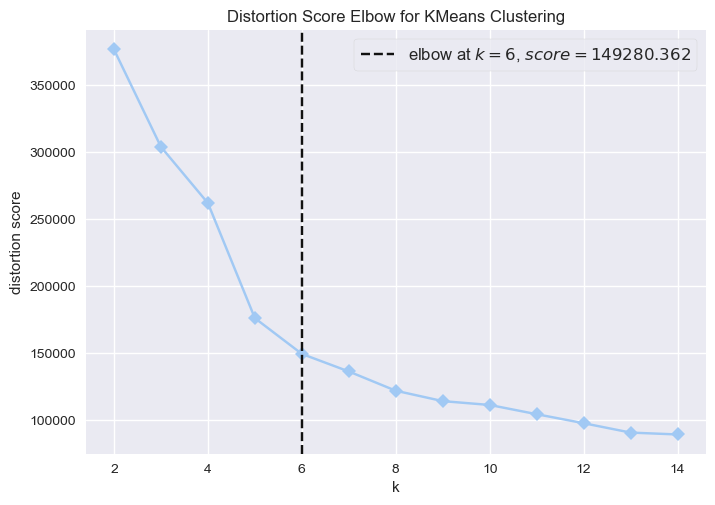

In [ ]:
subset_scaled = scale(subset)

elbow(subset_scaled)

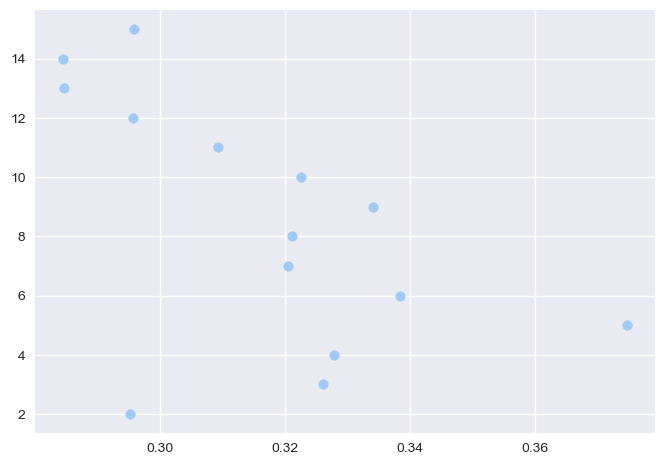

In [ ]:
visualize_silhouette(subset_scaled, 6)

#### Visualizing clusters using ACP

In [ ]:
subset_scaled = pd.DataFrame(subset_scaled, columns=subset.columns)
subset_scaled

,order_frequency,total_price,recency,review_score,comment
0,-0.159829,-0.102824,-0.825357,0.667574,1.171462
1,-0.159829,-0.609738,-0.805697,-0.114184,-0.853634
2,-0.159829,-0.348879,1.959873,-0.895943,-0.853634
3,-0.159829,-0.537133,0.544321,-0.114184,1.171462
4,-0.159829,0.140181,0.328056,0.667574,-0.853634
...,...,...,...,...,...
93353,-0.159829,8.406223,1.370059,0.667574,-0.853634
93354,-0.159829,-0.356127,0.157665,-0.114184,-0.853634
93355,-0.159829,-0.232922,2.163031,0.667574,-0.853634
93356,-0.159829,-0.139105,-0.779483,0.667574,1.171462


In [ ]:
subset_scaled_pca = pd.DataFrame(index=subset_scaled.index)
subset_scaled_pca["F1"] = subset_projected_values[:, 0]
subset_scaled_pca["F2"] = subset_projected_values[:, 1]
subset_scaled_pca["F3"] = subset_projected_values[:, 2]

In [ ]:
subset_scaled_pca

,F1,F2,F3
0,0.321554,-0.128878,-0.936119
1,-0.660130,-0.242364,-0.844359
2,-0.148184,-0.660672,1.937929
3,0.685668,-0.769148,0.353585
4,-1.015943,0.210704,0.375420
...,...,...,...
93353,1.231245,5.246009,2.882049
93354,-0.620483,-0.231331,0.145086
93355,-1.176578,-0.306447,2.106190
93356,0.310104,-0.158749,-0.897694


In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init="auto")
labels = kmeans.fit_predict(subset_scaled_pca)
subset_scaled_pca["cluster"] = labels

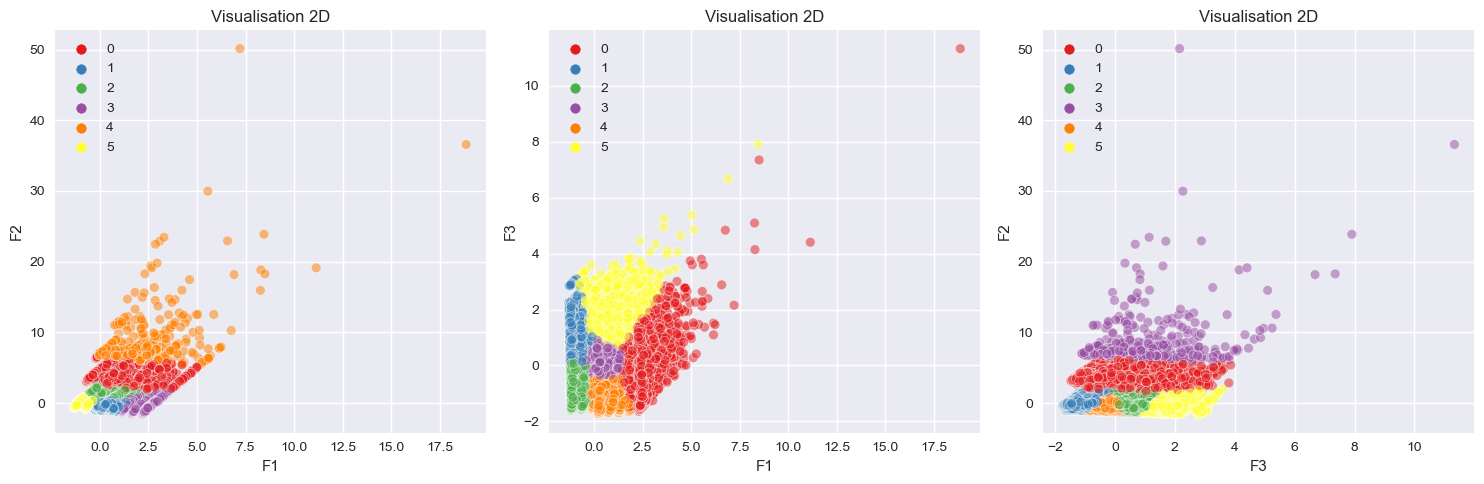

In [ ]:
plot_clusters(
    subset_scaled_pca,
    [
        ["F1", "F2"],
        ["F1", "F3"],
        ["F3", "F2"],
    ],
    6,
)

#### Visualizing clusters using TSNE

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init="auto")
labels = kmeans.fit_predict(subset_scaled)
subset_scaled["cluster"] = labels

/var/folders/ht/r34_b3vj4p7c88ck54235g_40000gn/T/ipykernel_92740/2097006994.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=T[:, 0], y=T[:, 1], c=subset_scaled["cluster"], palette="Set1")


<Axes: >

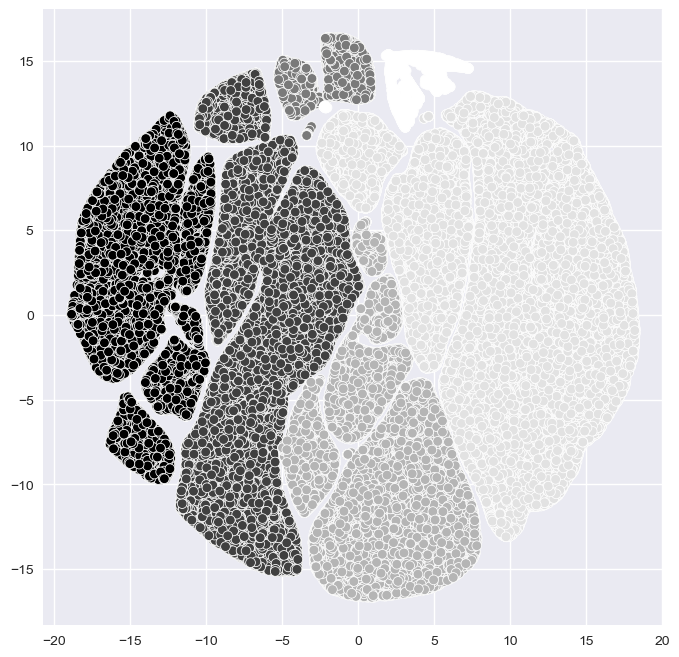

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=300, n_jobs=-1, init="pca")
T = tsne.fit_transform(subset_scaled)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=T[:, 0], y=T[:, 1],
                c=subset_scaled["cluster"], palette="Set1")
plt.show()

#### Interpreting results

In [ ]:
subset["cluster"] = subset_scaled["cluster"]

/var/folders/ht/r34_b3vj4p7c88ck54235g_40000gn/T/ipykernel_92740/1207647394.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["cluster"] = subset_scaled["cluster"]


In [ ]:
subset.groupby("cluster").agg(
    order_frequency=("order_frequency", "mean"),
    total_price=("total_price", "mean"),
    recency=("recency", "mean"),
    comment=("comment", "mean"),
    review_score=("review_score", "mean"),
    cluster_size=("cluster", "count"),
).round(2)

,order_frequency,total_price,recency,comment,review_score,cluster_size
cluster,,,,,,
0,2.11,308.53,219.29,0.42,4.20,2801
1,1.00,140.00,29.31,0.36,4.58,10938
2,1.00,316.03,265.50,0.03,4.52,18393
3,1.00,137.96,266.92,1.00,4.56,24905
4,1.00,191.99,237.25,0.82,1.17,10591
5,1.00,67.71,277.57,0.00,4.51,25730
